In [1104]:
class LayerManagerError(Exception):
    """レイヤーモジュールにおけるユーザ定義エラーのベースクラス"""
    pass


class AssignError(LayerManagerError):
    def __init__(self, value=None):
        if not value is None:
            self.value = value
            self.message = (str(value)
                         + ": Assigning that value is prohibited.")
        else:
            self.value = None
            self.message = "Assigning that value is prohibited."


    def __str__(self):
        return self.message


class UnmatchUnitError(LayerManagerError):
    def __init__(self, prev, n):
        self.prev = prev
        self.n = n

        self.message = "Unmatch units: {} and {}.".format(prev, n)


    def __str__(self):
        return self.message


class UndefinedLayerError(LayerManagerError):
    def __init__(self, type_name):
        self.type = type_name
        self.message = str(type_name) + ": Undefined layer type."


    def __str__(self):
        return self.message

In [1105]:
import numpy as np


class BaseLayer():
    """
    全ての元となるレイヤークラス
    中間層と出力層で共通する処理を記述する。
    """

    def __init__(self, *, prev=1, n=1,
                 name="", wb_width=5e-2,
                 act="ReLU", opt="Adam",
                 act_dic={}, opt_dic={}, **kwds):
        self.prev = prev  # 一つ前の層の出力数 = この層への入力数
        self.n = n        # この層の出力数 = 次の層への入力数
        self.name = name  # この層の名前

        # 重みとバイアスを設定
        self.w = wb_width*np.random.randn(prev, n)
        self.b = wb_width*np.random.randn(n)

        # 活性化関数(クラス)を取得
        self.act = get_act(act, **act_dic)

        # 最適化子(クラス)を取得
        self.opt = get_opt(opt, **opt_dic)


    def forward(self, x):
        """
        順伝播の実装
        """
        # 入力を記憶しておく
        self.x = x.copy()

        # 順伝播
        self.u = x@self.w + self.b
        self.y = self.act.forward(self.u)
        
        return self.y


    def backward(self, grad):
        """
        逆伝播の実装
        """
        dact = grad*self.act.backward(self.u, self.y)
        self.grad_w = self.x.T@dact
        self.grad_b = np.sum(dact, axis=0)
        self.grad_x = dact@self.w.T

        return self.grad_x


    def update(self, **kwds):
        """
        パラメータ学習の実装
        """
        dw, db = self.opt.update(self.grad_w, self.grad_b, **kwds)

        self.w += dw
        self.b += db

In [1106]:
import numpy as np


class MiddleLayer(BaseLayer):
    """
    中間層クラス
    入力層も実装上は中間層の一つとして取り扱います。
    """
    pass

In [1107]:
import numpy as np


class OutputLayer(BaseLayer):
    """
    出力層クラス
    """
    def __init__(self, *, err_func="Square", **kwds):
        # 損失関数(クラス)を取得
        self.errfunc = get_err(err_func)

        super().__init__(**kwds)
    

    def backward(self, t):
        """
        逆伝播の実装
        """
        # 出力層の活性化関数がsoftmax関数で損失関数が交差エントロピー誤差の場合
        # 誤差の伝播を場合分けしておく
        if isinstance(self.act, type(get_act("softmax"))) \
        and isinstance(self.errfunc, type(get_err("Cross"))):
            dact = self.y - t
            self.grad_w = self.x.T@dact
            self.grad_b = np.sum(dact, axis=0)
            self.grad_x = dact@self.w.T

            return self.grad_x
        elif isinstance(self.act, type(get_act("sigmoid"))) \
         and isinstance(self.errfunc, type(get_err("Binary"))):
            dact = self.y - t
            self.grad_w = self.x.T@dact
            self.grad_b = np.sum(dact, axis=0)
            self.grad_x = dact@self.w.T

            return self.grad_x
        else:
            grad = self.errfunc.backward(self.y, t)
            return super().backward(grad)


    def get_error(self, t):
        self.error = self.errfunc.forward(self.y, t)
        return self.errfunc.total_error()

In [1117]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import tqdm


class _TypeManager():
    """
    層の種類に関するマネージャクラス
    """
    N_TYPE = 2  # 層の種類数

    MIDDLE = 0  # 中間層のナンバリング
    OUTPUT = 1  # 出力層のナンバリング


class LayerManager(_TypeManager):
    """
    層を管理するためのマネージャクラス
    """
    def __init__(self, x, y):
        self.x_train, self.x_test = x
        self.y_train, self.y_test = y
        
        self.__layer_list = []  # レイヤーのリスト
        self.__name_list = []   # 各レイヤーの名前リスト
        self.__ntype = np.zeros(self.N_TYPE, dtype=int)  # 種類別レイヤーの数


    def __repr__(self):
        layerRepr= "layer_list: " + repr(self.__layer_list)
        nameRepr = "name_list: " + repr(self.__name_list)
        ntypeRepr = "ntype: " + repr(self.__ntype)
        return (layerRepr + "\n"
                + nameRepr + "\n"
                + ntypeRepr)


    def __str__(self):
        layerStr = "layer_list: " + str(self.__layer_list)
        nameStr = "name_list: " + str(self.__name_list)
        ntypeStr = "ntype: " + str(self.__ntype)
        return (layerStr + "\n"
                + nameStr + "\n"
                + ntypeStr)


    def __len__(self):
        """
        Pythonのビルドイン関数`len`から呼ばれたときの動作を記述。
        種類別レイヤーの数の総和を返します。
        """
        return int(np.sum(self.__ntype))


    def __getitem__(self, key):
        """
        例えば
        lm = LayerManager()

        +----------------+
        | (lmに要素を追加) |
        +----------------+

        x = lm[3].~~
        のように、リストや配列の要素にアクセスされたときに呼ばれるので、
        そのときの動作を記述。
        sliceやstr, intでのアクセスのみ許可します。
        """
        if isinstance(key, slice):
            # keyがスライスならレイヤーのリストをsliceで参照する。
            # 異常な値(Index out of rangeなど)が入力されたら
            # Pythonがエラーを出してくれます。
            return self.__layer_list[key]
        elif isinstance(key, str):
            # keyが文字列なら各レイヤーの名前リストからインデックスを取得して、
            # 該当するレイヤーのリストの要素を返す。
            if key in self.__name_list:
                index = self.__name_list.index(key)
                return self.__layer_list[index]
            else:
                # keyが存在しない場合はKeyErrorを出す。
                raise KeyError("{}: No such item".format(key))
        elif isinstance(key, int):
            # keyが整数ならレイヤーのリストの該当要素を返す。
            # 異常な値(Index out of rangeなど)が入力されたら
            # Pythonがエラーを出してくれます。
            return self.__layer_list[key]
        else:
            raise KeyError(key, ": Undefined such key type.")


    def __setitem__(self, key, value):
        """
        例えば
        lm = LayerManager()

        +----------------+
        | (lmに要素を追加) |
        +----------------+

        lm[1] = x
        のように、リストや配列の要素にアクセスされたときに呼ばれるので、
        そのときの動作を記述。
        要素の上書きのみ認め、新規要素の追加などは禁止します。
        """
        value_type = ""
        if isinstance(value, list):
            # 右辺で指定された'value'が'list'なら
            # 全ての要素が'BaseLayer'クラスかそれを継承していなければエラー。
            if not np.all(
                np.where(isinstance(value, BaseLayer), True, False)):
                self.AssignError()
            value_type = "list"
        elif isinstance(value, BaseLayer):
            # 右辺で指定された'value'が'BaseLayer'クラスか
            # それを継承していない場合はエラー。
            self.AssignError(type(value))
        if value_type == "":
            value_type = "BaseLayer"

        if isinstance(key, slice):
            # keyがスライスならレイヤーのリストの要素を上書きする。
            # ただし'value_type'が'list'でなければエラー。
            # 異常な値(Index out of rangeなど)が入力されたら
            # Pythonがエラーを出してくれます。
            if value_type != "list":
                self.AssignError(value_type)
            self.__layer_list[key] = value
        elif isinstance(key, str):
            # keyが文字列なら各レイヤーの名前リストからインデックスを取得して、
            # 該当するレイヤーのリストの要素を上書きする。
            # ただし'value_type'が'BaseLayer'でなければエラー。
            if value_type != "BaseLayer":
                raise AssignError(value_type)
            if key in self.__name_list:
                index = self.__name_list.index(key)
                self.__layer_list[index] = value
            else:
                # keyが存在しない場合はKeyErrorを出す。
                raise KeyError("{}: No such item".format(key))
        elif isinstance(key, int):
            # keyが整数ならレイヤーのリストの該当要素を上書きする。
            # ただし'value_type'が'BaseLayer'でなければエラー。
            # また、異常な値(Index out of rangeなど)が入力されたら
            # Pythonがエラーを出してくれます。
            if value_type != "BaseLayer":
                raise AssignError(value_type)
            self.__layer_list[key] = value
        else:
            raise KeyError(key, ": Undefined such key type.")


    def __delitem__(self, key):
        """
        例えば
        lm = LayerManager()

        +----------------+
        | (lmに要素を追加) |
        +----------------+

        del lm[2]
        のように、del文でリストや配列の要素にアクセスされたときに呼ばれるので、
        そのときの動作を記述。
        指定要素が存在すれば削除、さらにリネームを行います。
        """
        if isinstance(key, slice):
            # keyがスライスならそのまま指定の要素を削除
            # 異常な値(Index out of rangeなど)が入力されたら
            # Pythonがエラーを出してくれます。
            del self.__layer_list[slice]
            del self.__name_list[slice]
        elif isinstance(key, str):
            # keyが文字列なら各レイヤーの名前リストからインデックスを取得して、
            # 該当する要素を削除する。
            if key in self.__name_list:
                del self.__layer_list[index]
                del self.__name_list[index]
            else:
                # keyが存在しない場合はKeyErrorを出す。
                raise KeyError("{}: No such item".format(key))
        elif isinstance(key, int):
            # keyが整数ならレイヤーのリストの該当要素を削除する。
            # 異常な値(Index out of rangeなど)が入力されたら
            # Pythonがエラーを出してくれます。
            del self.__layer_list[key]
        else:
            raise KeyError(key, ": Undefined such key type.")

        # リネームする
        self._rename()


    def _rename(self):
        """
        リスト操作によってネームリストのネーミングがルールに反するものになった場合に
        改めてルールを満たすようにネーミングリストおよび各レイヤーの名前を変更する。

        ネーミングルールは[レイヤーの種類][何番目か]とします。
        レイヤーの種類はMiddleLayerならMiddle
                     OutputLayerならOutput
        のように略します。
        何番目かというのは種類別でカウントします。

        また、ここで改めて__ntypeのカウントを行います。
        """
        # 種類別レイヤーの数を初期化
        self.__ntype = np.zeros(self.N_TYPE)

        # 再カウントと各レイヤーのリネーム
        for i in range(len(self)):
            if "Middle" in self.__name_list[i]:
                self.__ntype[self.MIDDLE] += 1
                self.__name_list[i] = "Middle{}".format(
                        self.__ntype[self.MIDDLE])
                self.__layer_list[i].name = "Middle{}".format(
                        self.__ntype[self.MIDDLE])
            elif "Output" in self.__name_list[i]:
                self.__ntype[self.OUTPUT] += 1
                self.__name_list[i] = "Output{}".format(
                        self.__ntype[self.OUTPUT])
                self.__layer_list[i].name = "Output{}".format(
                        self.__ntype[self.OUTPUT])
            else:
                raise UndefinedLayerType(self.__name_list[i])

    def append(self, *, name="Middle", **kwds):
        """
        リストに要素を追加するメソッドでお馴染みのappendメソッドの実装。
        """
        if "prev" in kwds:
            # 'prev'がキーワードに含まれている場合、
            # 一つ前の層の要素数を指定していることになります。
            # 基本的に最初のレイヤーを挿入する時を想定していますので、
            # それ以外は基本的に自動で決定するため指定しません。
            if len(self) != 0:
                if kwds["prev"] != self.__layer_list[-1].n:
                    # 最後尾のユニット数と一致しなければエラー。
                    raise UnmatchUnitError(self.__layer_list[-1].n,
                                           kwds["prev"])
        else:
            if len(self) == 0:
                # 最初の層は必ず入力ユニットの数を指定する必要があります。
                raise UnmatchUnitError("Input units", "Unspecified")
            else:
                # 最後尾のレイヤーのユニット数を'kwds'に追加
                kwds["prev"] = self.__layer_list[-1].n

        # レイヤーの種類を読み取り、ネーミングルールに則った名前に変更する
        if name == "Middle" or name == "mid" or name == "m":
            name = "Middle"
        elif name == "Output" or name == "out" or name == "o":
            name = "Output"
        else:
            raise UndefinedLayerError(name)

        # レイヤーを追加する。
        if name == "Middle":
            # 種類別レイヤーをインクリメントして
            self.__ntype[self.MIDDLE] += 1
            # 名前に追加し
            name += str(self.__ntype[self.MIDDLE])
            # ネームリストに追加し
            self.__name_list.append(name)
            # 最後にレイヤーを生成してリストに追加します。
            self.__layer_list.append(
                    MiddleLayer(name=name, **kwds))
        elif name == "Output":
            # こちらも同様です。
            self.__ntype[self.OUTPUT] += 1
            name += str(self.__ntype[self.OUTPUT])
            self.__name_list.append(name)
            self.__layer_list.append(
                    OutputLayer(name=name, **kwds))
        # ここでelse文を描いていないのはネーミングルールに則った名前に変更する
        # 段階で既に異常な'name'は省かれているからです。


    def extend(self, lm):
        """
        extendメソッドでは既にある別のレイヤーマネージャ'lm'の要素を
        全て追加します。
        """
        if not isinstance(lm, LayerManager):
            # 'lm'のインスタンスがLayerManagerでなければエラー。
            raise TypeError(type(lm), ": Unexpected type.")
        if len(self) != 0:
            if self.__layer_list[-1].n != lm[0].prev:
                # 自分の最後尾のレイヤーのユニット数と
                # 'lm'の最初のレイヤーの入力数が一致しない場合はエラー。
                raise UnmatchUnitError(self.__layer_list[-1].n,
                                       lm[0].prev)

        # それぞれ'extend'メソッドで追加
        self.__layer_list.extend(lm.layer_list)
        self.__name_list.extend(lm.name_list)

        # リネームする
        self._rename()


    def insert(self, prev_name, name="Middle", **kwds):
        """
        insertメソッドでは、前のレイヤーの名前を指定しそのレイヤーと結合するように
        要素を追加します。
        """
        # 'prev_name'が存在しなければエラー。
        if not prev_name in self.__name_list:
            raise KeyError(prev_name, ": No such key.")
        # 'prev'がキーワードに含まれている場合、
        # 'prev_name'で指定されているレイヤーのユニット数と一致しなければエラー。
        if "prev" in kwds:
            if kwds["prev"] \
                != self.__layer_list[self.index(prev_name)].n:
                raise UnmatchUnitError(
                    kwds["prev"],
                    self.__layer_list[self.index(prev_name)].n)
        # 'n'がキーワードに含まれている場合、
        if "n" in kwds:
            # 'prev_name'が最後尾ではない場合は
            if prev_name != self.__name_list[-1]:
                # 次のレイヤーのユニット数と一致しなければエラー。
                if kwds["n"] != self.__layer_list[
                        self.index(prev_name)+1].prev:
                    raise UnmatchUnitError(
                        kwds["n"],
                        self.__layer_list[self.index(prev_name)].prev)
        # まだ何も要素がない場合は'append'メソッドを用いるようにエラーを出す。
        if len(self) == 0:
            raise RuntimeError(
                "You have to use 'append' method instead.")

        # 挿入場所のインデックスを取得
        index = self.index(prev_name) + 1

        # レイヤーの種類を読み取り、ネーミングルールに則った名前に変更する
        if name == "Middle" or name == "mid" or name == "m":
            name = "Middle"
        elif name == "Output" or name == "out" or name == "o":
            name = "Output"
        else:
            raise UndefinedLayerError(name)

        # 要素を挿入する
        # このとき、'name'はまだネーミングルールに則っていませんが、
        # あとでリネームするので気にしないでOKです。
        if "Middle" in name:
            self.__layer_list.insert(index,
                                     MiddleLayer(name=name, **kwds))
            self.__name_list.insert(index, name)
        elif "Output" in name:
            self.__layer_list.insert(index,
                                     OutputLayer(name=name, **kwds))
            self.__name_list.insert(index, name)

        # リネームする
        self._rename()


    def extend_insert(self, prev_name, lm):
        """
        こちらはオリジナル関数です。
        extendメソッドとinsertメソッドを組み合わせたような動作をします。
        簡単に説明すると、別のレイヤーマネージャをinsertする感じです。
        """
        if not isinstance(lm, LayerManager):
            # 'lm'のインスタンスがLayerManagerでなければエラー。
            raise TypeError(type(lm), ": Unexpected type.")
        # 'prev_name'が存在しなければエラー。
        if not prev_name in self.__name_list:
            raise KeyError(prev_name, ": No such key.")
        # 指定場所の前後のレイヤーとlmの最初・最後のレイヤーのユニット数が
        # それぞれ一致しなければエラー。
        if len(self) != 0:
            if self.__layer_list[self.index(prev_name)].n \
                    != lm.layer_list[0].prev:
                # 自分の指定場所のユニット数と'lm'の最初のユニット数が
                # 一致しなければエラー。
                raise UnmatchUnitError(
                    self.__layer_list[self.index(prev_name)].n,
                    lm.layer_list[0].prev)
            if prev_name != self.__name_list[-1]:
                # 'prev_name'が自分の最後尾のレイヤーでなく
                if lm.layer_list[-1].n \
                    != self.__layer_list[self.index(prev_name)+1].prev:
                    # 'lm'の最後尾のユニット数と自分の指定場所の次のレイヤーの
                    # 'prev'ユニット数と一致しなければエラー。
                    raise UnmatchUnitError(
                        lm.layer_list[-1].n,
                        self.__layer_list[self.index(prev_name)+1].prev)
        else:
            # 自分に何の要素もない場合は'extend'メソッドを使うようにエラーを出す。
            raise RuntimeError(
                "You have to use 'extend' method instead.")

        # 挿入場所のインデックスを取得
        index = self.index(prev_name) + 1

        # 挿入場所以降の要素を'buf'に避難させてから一旦取り除き、
        # extendメソッドを使って要素を追加
        layer_buf = self.__layer_list[index:]
        name_buf = self.__name_list[index:]
        del self.__layer_list[index:]
        del self.__name_list[index:]
        self.extend(lm)

        # 避難させていた要素を追加する
        self.__layer_list.extend(layer_buf)
        self.__name_list.extend(name_buf)

        # リネームする
        self._rename()


    def remove(self, key):
        """
        removeメソッドでは指定の名前の要素を削除します。
        インデックスでの指定も許可します。
        """
        # 既に実装している'del'文でOKです。
        del self[key]


    def index(self, target):
        return self.__name_list.index(target)


    def name(self, indices):
        return self.__name_list[indices]


    @property
    def layer_list(self):
        return self.__layer_list


    @property
    def name_list(self):
        return self.__name_list


    @property
    def ntype(self):
        return self.__ntype
    
    
    def training(self, epoch, n_batch=16, threshold=1e-8,
                         show_error=True, **kwds):
        if show_error:
            self.error_list = []
        if self.make_anim:
            self.images = []
        
        n_in = self.__layer_list[0].prev
        n_out = self.__layer_list[-1].n
        n_train = self.x_train.size//n_batch
        n_test = self.x_test.size
        
        # 学習開始
        error = 0
        error_prev = 0
        rand_index = np.arange(self.x_train.size)
        for t in tqdm.tqdm(range(1, epoch+1)):
            #シーン作成
            if self.make_anim:
                self.make_scene(t, epoch)
            
            # 誤差計算
            x_in = self.x_test.reshape(n_test, n_in)
            for ll in self.__layer_list:
                x_in = ll.forward(x_in)
            error = lm[-1].get_error(self.y_test.reshape(n_test, n_out))
            if show_error:
                self.error_list.append(error)

            # 収束判定
            if abs(error - error_prev) < threshold:
                print("end learning...")
                break
            else:
                error_prev = error

            np.random.shuffle(rand_index)
            for i in range(n_train):
                rand = rand_index[i*n_in : (i+n_batch)*n_in]

                x_in = self.x_train[rand].reshape(-1, n_in)
                for ll in self.__layer_list:
                    x_in = ll.forward(x_in)

                y_in = self.y_train[rand].reshape(-1, n_out)
                for ll in self.__layer_list[::-1]:
                    y_in = ll.backward(y_in)

                for ll in self.__layer_list:
                    ll.update()
        
        if show_error:
            # 誤差遷移表示
            self.show_errors(**kwds)
    
    
    def show_errors(self, title="error transition",
                                  xlabel="epoch", ylabel="error", fname="error_transition.png",
                                  **kwds):
        fig, ax = plt.subplots(1)
        fig.suptitle(title)
        ax.set_yscale("log")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.grid()
        ax.plot(self.error_list)
        fig.show()
        if len(fname) != 0:
            fig.savefig(fname)
    
    
    def ready_anim(self, n_image, x, y, title="animation",
                                xlabel="x", ylabel="y", ex_color="r", color="b",
                                x_left=0, x_right=0, y_down = 1, y_up = 1):
        self.n_image = n_image
        self.x = x
        self.color = color
        self.make_anim = True
        
        self.anim_fig, self.anim_ax = plt.subplots(1)
        self.anim_fig.suptitle(title)
        self.anim_ax.set_xlabel(xlabel)
        self.anim_ax.set_ylabel(ylabel)
        self.anim_ax.set_xlim(np.min(x) - x_left, np.max(x) + x_right)
        self.anim_ax.set_ylim(np.min(y) - y_down, np.max(y) + y_up)
        self.anim_ax.grid()
        self.anim_ax.plot(x, y, color=ex_color)
        
        return self.anim_fig, self.anim_ax
    
    
    def make_scene(self, t, epoch):
        # シーン作成
        if t % (epoch/self.n_image) == 1:
            x_in = self.x.reshape(-1, 1)
            for ll in self.__layer_list:
                x_in = ll.forward(x_in)
            im, = self.anim_ax.plot(self.x, ll.y, color=self.color)
            self.images.append([im])

In [1118]:
import numpy as np


class Error():
    def __init__(self, *args, **kwds):
        self.error = 0
    
    
    def forward(self, *args, **kwds):
        pass
    
    
    def backward(self, *args, **kwds):
        pass
    
    
    def total_error(self, *args, **kwds):
        return np.sum(self.error)/self.error.size


class SquareError(Error):
    def forward(self, y, t, *args, **kwds):
        self.error = 0.5 * (y - t)**2
        return self.error
    
    
    def backward(self, y, t, *args, **kwds):
        return y - t


class BinaryCrossEntropy(Error):
    def forward(self, y, t, *args, **kwds):
        self.error = - t*np.log(y) - (1 - t)*np.log(1 - y)
        return self.error
    
    
    def backward(self, y, t, *args, **kwds):
        return (y - t) / (y*(1 - y))
    

class CrossEntropy(Error):
    def forward(self, y, t, *args, **kwds):
        self.error = - t*np.log(y)
        return self.error
    
    
    def backward(self, y, t, *args, **kwds):
        return - t/y

In [1119]:
_err_dic = {"Square": SquareError,
            "Binary": BinaryCrossEntropy,
            "Cross": CrossEntropy,
           }


def get_err(name, *args, **kwds):
    if name in _err_dic.keys():
        errfunc = _err_dic[name](*args, **kwds)
    else:
        raise ValueError(name + ": Unknown error function")

    return errfunc

In [1120]:
import numpy as np


class Activator():
    def __init__(self, *args, **kwds):
        pass


    def forward(self, *args, **kwds):
        raise Exception("Not Implemented")


    def backward(self, *args, **kwds):
        raise Exception("Not Implemented")


    def update(self, *args, **kwds):
        pass


class step(Activator):
    def forward(self, x, *args, **kwds):
        return np.where(x > 0, 1, 0)


    def backward(self, x, *args, **kwds):
        return np.zeros_like(x)


class identity(Activator):
    def forward(self, x, *args, **kwds):
        return x


    def backward(self, x, *args, **kwds):
        return np.ones_like(x)


class bentIdentity(Activator):
    def forward(self, x, *args, **kwds):
        return 0.5*(np.sqrt(x**2 + 1) - 1) + x


    def backward(self, x, *args, **kwds):
        return 0.5*x/np.sqrt(x**2 + 1) + 1


class hardShrink(Activator):
    def __init__(self, lambda_=0.5, *args, **kwds):
        self.lambda_ = lambda_
        super().__init__(*args, **kwds)


    def forward(self, x, *args, **kwds):
        return np.where((-self.lambda_ <= x) & (x <= self.lambda_),
                        0, x)


    def backward(self, x, *args, **kwds):
        return np.where((-self.lambda_ <= x) & (x <= self.lambda_),
                        0, 1)


class softShrink(Activator):
    def __init__(self, lambda_=0.5, *args, **kwds):
        self.lambda_ = lambda_
        super().__init__(*args, **kwds)


    def forward(self, x, *args, **kwds):
        return np.where(x < -self.lambda_, x + self.lambda_,
                        np.where(x > self.lambda_, x - self.lambda_, 0))


    def backward(self, x, *args, **kwds):
        return np.where((-self.lambda_ <= x) & (x <= self.lambda_),
                        0, 1)


class threshold(Activator):
    def __init__(self, threshold, value, *args, **kwds):
        self.threshold = threshold
        self.value = value
        super().__init__(*args, **kwds)


    def forward(self, x, *args, **kwds):
        return np.where(x > self.threshold, x, self.value)


    def backward(self, x, *args, **kwds):
        return np.where(x > self.threshold, 1, 0)


class sigmoid(Activator):
    def forward(self, x, *args, **kwds):
        return 1/(1 + np.exp(-x))


    def backward(self, x, y, *args, **kwds):
        return y*(1 - y)


class hardSigmoid(Activator):
    def forward(self, x, *args, **kwds):
        return np.clip(0.2*x + 0.5, 0, 1)


    def backward(self, x, *args, **kwds):
        return np.where((x > 2.5) | (x < -2.5), 0, 0.2)


class logSigmoid(Activator):
    def forward(self, x, *args, **kwds):
        return -np.log(1 + np.exp(-x))


    def backward(self, x, *args, **kwds):
        return 1/(1 + np.exp(x))


class act_tanh(Activator):
    def forward(self, x, *args, **kwds):
        return np.tanh(x)


    def backward(self, x, *args, **kwds):
        return 1 - np.tanh(x)**2


class hardtanh(Activator):
    def forward(self, x, *args, **kwds):
        return np.clip(x, -1, 1)


    def backward(self, x, *args, **kwds):
        return np.where((-1 <= x) & (x <= 1), 1, 0)


class tanhShrink(Activator):
    def forward(self, x, *args, **kwds):
        return x - np.tanh(x)


    def backward(self, x, *args, **kwds):
        return np.tanh(x)**2


class ReLU(Activator):
    def forward(self, x, *args, **kwds):
        return np.maximum(0, x)


    def backward(self, x, *args, **kwds):
        return np.where(x > 0, 1, 0)


class ReLU6(Activator):
    def forward(self, x, *args, **kwds):
        return np.clip(x, 0, 6)


    def backward(self, x, *args, **kwds):
        return np.where((0 < x) & (x < 6), 1, 0)


class leakyReLU(Activator):
    def __init__(self, alpha=1e-2, *args, **kwds):
        self.alpha = alpha
        super().__init__(*args, **kwds)


    def forward(self, x, *args, **kwds):
        return np.maximum(self.alpha * x, x)


    def backward(self, x, *args, **kwds):
        return np.where(x < 0, self.alpha, 1)


class ELU(Activator):
    def __init__(self, alpha=1., *args, **kwds):
        self.alpha = alpha
        super().__init__(*args, **kwds)


    def forward(self, x, *args, **kwds):
        return np.where(x >= 0, x, self.alpha*(np.exp(x) - 1))


    def backward(self, x, *args, **kwds):
        return np.where(x >= 0, 1, self.alpha*np.exp(x))


class SELU(Activator):
    def __init__(self, lambda_=1.0507, alpha=1.67326, *args, **kwds):
        self.lambda_ = lambda_
        self.alpha = alpha
        super().__init__(*args, **kwds)


    def forward(self, x, *args, **kwds):
        return np.where(x >= 0,
                        self.lambda_*x,
                        self.lambda_*self.alpha*(np.exp(x) - 1))


    def backward(self, x, *args, **kwds):
        return np.where(x >= 0,
                        self.lambda_,
                        self.lambda_*self.alpha*np.exp(x))


class CELU(Activator):
    def __init__(self, alpha=1., *args, **kwds):
        self.alpha = alpha
        super().__init__(*args, **kwds)


    def forward(self, x, *args, **kwds):
        return np.where(x >= 0,
                        x,
                        self.alpha*(np.exp(x/self.alpha) - 1))


    def backward(self, x, *args, **kwds):
        return np.where(x >= 0, 1, np.exp(x/self.alpha))


class softmax(Activator):
    def forward(self, x, *args, **kwds):
        return np.exp(x)/np.sum(np.exp(x))


    def backward(self, x, *args, **kwds):
        return np.exp(x)*(np.sum(np.exp(x))
                          - np.exp(x))/np.sum(np.exp(x))**2


class softmin(Activator):
    def forward(self, x, *args, **kwds):
        return np.exp(-x)/np.sum(np.exp(-x))


    def backward(self, x, *args, **kwds):
        return -(np.exp(x)*(np.sum(np.exp(-x)) - np.exp(x))
                 /np.sum(np.exp(-x))**2)


class logSoftmax(Activator):
    def forward(self, x, *args, **kwds):
        return np.log(np.exp(x)/np.sum(np.exp(x)))


    def backward(self, x, *args, **kwds):
        y = np.sum(np.exp(x))
        return (y - np.exp(x))/y


class softplus(Activator):
    def forward(self, x, *args, **kwds):
        return np.logaddexp(x, 0)


    def backward(self, x, *args, **kwds):
        return 1/(1 + np.exp(-x))


class softsign(Activator):
    def forward(self, x, *args, **kwds):
        return x/(1 + np.abs(x))


    def backward(self, x, *args, **kwds):
        return 1/(1 + np.abs(x)) ** 2


class Swish(Activator):
    def __init__(self, beta=1, *args, **kwds):
        self.beta = beta
        super().__init__(*args, **kwds)


    def forward(self, x, *args, **kwds):
        return x/(1 + np.exp(-self.beta*x))


    def backward(self, x, y, *args, **kwds):
        return self.beta*y + (1 - self.beta*y)/(1 + np.exp(-self.beta*x))


    def d2y(self, x, *args, **kwds):
        return (-0.25*self.beta*(self.beta*x*np.tanh(0.5*self.beta*x) - 2)
                               *(1 - np.tanh(0.5*self.beta*x)**2))


class Mish(Activator):
    def forward(self, x, *args, **kwds):
        return x*np.tanh(np.logaddexp(x, 0))


    def backward(self, x, *args, **kwds):
        omega = (4*(x + 1) + 4*np.exp(2*x)
                 + np.exp(3*x) + (4*x + 6)*np.exp(x))
        delta = 2*np.exp(x) + np.exp(2*x) + 2
        return np.exp(x)*omega/delta**2


    def d2y(self, x, *args, **kwds):
        omega = (2*(x + 2)
                 + np.exp(x)*(np.exp(x)*(-2*np.exp(x)*(x - 1) - 3*x + 6)
                              + 2*(x + 4)))
        delta = np.exp(x)*(np.exp(x) + 2) + 2
        return 4*np.exp(x)*omega/delta**3


class tanhExp(Activator):
    def forward(self, x, *args, **kwds):
        return x*np.tanh(np.exp(x))


    def backward(self, x, *args, **kwds):
        tanh_exp = np.tanh(np.exp(x))
        return tanh_exp - x*np.exp(x)*(tanh_exp**2 - 1)


    def d2y(self, x, *args, **kwds):
        tanh_exp = np.tanh(np.exp(x))
        return (np.exp(x)*(-x + 2*np.exp(x)*x*tanh_exp - 2)
                         *(tanh_exp**2 - 1))


class maxout(Activator):
    def __init__(self, n_prev, n, k, wb_width=5e-2, *args, **kwds):
        self.n_prev = n_prev
        self.n = n
        self.k = k
        self.w = wb_width*np.random.rand((n_prev, n*k))
        self.b = wb_width*np.random.rand(n*k)

        super().__init__(*args, **kwds)


    def forward(self, x, *args, **kwds):
        self.x = x.copy()
        self.z = np.dot(self.w.T, x) + self.b
        self.z = self.z.reshape(self.n, self.k)
        self.y = np.max(self.z, axis=1)
        return self.y

    def backward(self, g, *args, **kwds):
        self.dw = np.sum(np.dot(self.w, self.x))

In [1121]:
_act_dic = {"step": step,
            "identity": identity,
            "bent-identity": bentIdentity,
            "hard-shrink": hardShrink,
            "soft-shrink": softShrink,
            "threshold": threshold,
            "sigmoid": sigmoid,
            "hard-sigmoid": hardSigmoid,
            "log-sigmoid": logSigmoid,
            "tanh": act_tanh,
            "tanh-shrink": tanhShrink,
            "hard-tanh":hardtanh,
            "ReLU": ReLU,
            "ReLU6": ReLU6,
            "leaky-ReLU": leakyReLU,
            "ELU": ELU,
            "SELU": SELU,
            "CELU": CELU,
            "softmax": softmax,
            "softmin": softmin,
            "log-softmax": logSoftmax,
            "softplus": softplus,
            "softsign": softsign,
            "Swish": Swish,
            "Mish": Mish,
            "tanhExp": tanhExp,
           }


def get_act(name, *args, **kwds):
    if name in _act_dic.keys():
        activator = _act_dic[name](*args, **kwds)
    else:
        raise ValueError(name + ": Unknown activator")

    return activator

In [1122]:
import numpy as np


class Optimizer():
    """
    最適化手法が継承するスーパークラス。
    """
    def __init__(self, *args, **kwds):
        pass


    def update(self, *args, **kwds):
        pass


class SGD(Optimizer):
    def __init__(self, eta=1e-2, *args, **kwds):
        super().__init__(*args, **kwds)

        self.eta = eta


    def update(self, grad_w, grad_b, *args, **kwds):
        dw = -self.eta*grad_w
        db = -self.eta*grad_b
        return dw, db


class MSGD(Optimizer):
    def __init__(self, eta=1e-2, mu=0.9, *args, **kwds):
        super().__init__(*args, **kwds)

        self.eta = eta
        self.mu = mu

        # 一つ前のステップの値を保持する
        self.dw = 0
        self.db = 0


    def update(self, grad_w, grad_b, *args, **kwds):
        dw = self.mu*self.dw - (1-self.mu)*self.eta*grad_w
        db = self.mu*self.db - (1-self.mu)*self.eta*grad_b

        # コピーではなくビューで代入しているのは、これらの値が使われることはあっても
        # 変更されることはないためです。
        self.dw = dw
        self.db = db

        return dw, db


class NAG(Optimizer):
    def __init__(self, eta=1e-2, mu=0.9, *args, **kwds):
        super().__init__(*args, **kwds)

        self.eta = eta
        self.mu = mu

        # 一つ前のステップの値を保持
        self.dw = 0
        self.db = 0


    def update(self, grad_w, grad_b, w=0, b=0, dfw=None, dfb=None,
               nargs=2, *args, **kwds):
        if nargs == 1:
            grad_w = dfw(w + self.mu*self.dw)
            grad_b = 0
        elif nargs == 2:
            grad_w = dfw(w + self.mu*self.dw, b + self.mu*self.db)
            grad_b = dfb(w + self.mu*self.dw, b + self.mu*self.db)

        dw = self.mu*self.dw - (1-self.mu)*self.eta*grad_w
        db = self.mu*self.db - (1-self.mu)*self.eta*grad_b

        # コピーではなくビューで代入しているのは、これらの値が使われることはあっても
        # 変更されることはないためです。
        self.dw = dw
        self.db = db

        return dw, db


class AdaGrad(Optimizer):
    def __init__(self, eta=1e-3, *args, **kwds):
        super().__init__(*args, **kwds)

        self.eta = eta

        # 一つ前のステップの値を保持する
        self.gw = 0
        self.gb = 0


    def update(self, grad_w, grad_b, *args, **kwds):
        self.gw += grad_w*grad_w
        self.gb += grad_b*grad_b

        dw = -self.eta*grad_w/np.sqrt(self.gw)
        db = -self.eta*grad_b/np.sqrt(self.gb)

        return dw, db


class RMSprop(Optimizer):
    def __init__(self, eta=1e-2, rho=0.99, eps=1e-8, *args, **kwds):
        super().__init__(*args, **kwds)

        self.eta = eta
        self.rho = rho
        self.eps = eps

        # 一つ前のステップの値を保持する
        self.vw = 0
        self.vb = 0


    def update(self, grad_w, grad_b, *args, **kwds):
        self.vw += (1-self.rho)*(grad_w**2 - self.vw)
        self.vb += (1-self.rho)*(grad_b**2 - self.vb)

        dw = -self.eta*grad_w/np.sqrt(self.vw+self.eps)
        db = -self.eta*grad_b/np.sqrt(self.vb+self.eps)

        return dw, db


class AdaDelta(Optimizer):
    def __init__(self, rho=0.95, eps=1e-6, *args, **kwds):
        super().__init__(*args, **kwds)

        self.rho = rho
        self.eps = eps

        # 一つ前のステップの値を保持する
        self.vw = 0
        self.vb = 0
        self.uw = 0
        self.ub = 0


    def update(self, grad_w, grad_b, *args, **kwds):
        self.vw += (1-self.rho)*(grad_w**2 - self.vw)
        self.vb += (1-self.rho)*(grad_b**2 - self.vb)

        dw = -grad_w*np.sqrt(self.uw+self.eps)/np.sqrt(self.vw+self.eps)
        db = -grad_b*np.sqrt(self.ub+self.eps)/np.sqrt(self.vb+self.eps)

        self.uw += (1-self.rho)*(dw**2 - self.uw)
        self.ub += (1-self.rho)*(db**2 - self.ub)

        return dw, db


class Adam(Optimizer):
    def __init__(self, alpha=1e-3, beta1=0.9, beta2=0.999, eps=1e-8,
                 *args, **kwds):
        super().__init__(*args, **kwds)

        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps

        # 一つ前のステップの値を保持する
        self.mw = 0
        self.mb = 0
        self.vw = 0
        self.vb = 0


    def update(self, grad_w, grad_b, t=1, *args, **kwds):
        self.mw += (1-self.beta1)*(grad_w - self.mw)
        self.mb += (1-self.beta1)*(grad_b - self.mb)
        self.vw += (1-self.beta2)*(grad_w**2 - self.vw)
        self.vb += (1-self.beta2)*(grad_b**2 - self.vb)

        alpha_t = self.alpha*np.sqrt(1-self.beta2**t)/(1-self.beta1**t)

        dw = -alpha_t*self.mw/(np.sqrt(self.vw+self.eps))
        db = -alpha_t*self.mb/(np.sqrt(self.vb+self.eps))

        return dw, db


class RMSpropGraves(Optimizer):
    def __init__(self, eta=1e-4, rho=0.95, eps=1e-4, *args, **kwds):
        super().__init__(*args, **kwds)

        self.eta = eta
        self.rho = rho
        self.eps = eps

        # 一つ前のステップの値を保持する
        self.mw = 0
        self.mb = 0
        self.vw = 0
        self.vb = 0


    def update(self,grad_w, grad_b, *args, **kwds):
        self.mw += (1-self.rho)*(grad_w - self.mw)
        self.mb += (1-self.rho)*(grad_b - self.mb)
        self.vw += (1-self.rho)*(grad_w**2 - self.vw)
        self.vb += (1-self.rho)*(grad_b**2 - self.vb)

        dw = -self.eta*grad_w/np.sqrt(self.vw - self.mw**2 + self.eps)
        db = -self.eta*grad_b/np.sqrt(self.vb - self.mb**2 + self.eps)

        return dw, db


class SMORMS3(Optimizer):
    def __init__(self, eta=1e-3, eps=1e-8, *args, **kwds):
        super().__init__(*args, **kwds)

        self.eta = eta
        self.eps = eps

        # 一つ前のステップの値を保持する
        self.zetaw = 0
        self.zetab = 0
        self.sw = 1
        self.sb = 1
        self.mw = 0
        self.mb = 0
        self.vw = 0
        self.vb = 0


    def update(self, grad_w, grad_b, *args, **kwds):
        rhow = 1/(1+self.sw)
        rhob = 1/(1+self.sb)

        self.mw += (1-rhow)*(grad_w - self.mw)
        self.mb += (1-rhob)*(grad_b - self.mb)
        self.vw += (1-rhow)*(grad_w**2 - self.vw)
        self.vb += (1-rhob)*(grad_b**2 - self.vb)

        self.zetaw = self.mw**2 / (self.vw + self.eps)
        self.zetaw = self.mb**2 / (self.vb + self.eps)

        dw = -grad_w*(np.minimum(self.eta, self.zetaw)
                      /np.sqrt(self.vw + self.eps))
        db = -grad_b*(np.minimum(self.eta, self.zetab)
                      /np.sqrt(self.vb + self.eps))

        self.sw = 1 + (1 - self.zetaw)*self.sw
        self.sb = 1 + (1 - self.zetab)*self.sb

        return dw, db


class AdaMax(Optimizer):
    def __init__(self, alpha=2e-3, beta1=0.9, beta2=0.999,
                 *args, **kwds):
        super().__init__(*args, **kwds)

        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2

        # 一つ前のステップの値を保持する
        self.mw = 0
        self.mb = 0
        self.uw = 0
        self.ub = 0


    def update(self, grad_w, grad_b, t=1, *args, **kwds):
        self.mw += (1-self.beta1)*(grad_w - self.mw)
        self.mb += (1-self.beta1)*(grad_b - self.mb)
        self.uw = np.maximum(self.beta2*self.uw, np.abs(grad_w))
        self.ub = np.maximum(self.beta2*self.ub, np.abs(grad_b))

        alpha_t = self.alpha/(1 - self.beta1**t)

        dw = -alpha_t*self.mw/self.uw
        db = -alpha_t*self.mb/self.ub

        return dw, db


class Nadam(Optimizer):
    def __init__(self, alpha=2e-3, mu=0.975, nu=0.999, eps=1e-8,
                 *args, **kwds):
        super().__init__(*args, **kwds)

        self.alpha = alpha
        self.mu = mu
        self.nu = nu
        self.eps = eps

        # 一つ前のステップの値を保持する
        self.mw = 0
        self.mb = 0
        self.vw = 0
        self.vb = 0


    def update(self, grad_w, grad_b, t=1, *args, **kwds):
        self.mw += (1-self.mu)*(grad_w - self.mw)
        self.mb += (1-self.mu)*(grad_b - self.mb)
        self.vw += (1-self.nu)*(grad_w**2 - self.vw)
        self.vb += (1-self.nu)*(grad_b**2 - self.vb)

        mhatw = (self.mu*self.mw/(1-self.mu**(t+1))
                 + (1-self.mu)*grad_w/(1-self.mu**t))
        mhatb = (self.mu*self.mb/(1-self.mu**(t+1))
                 + (1-self.mu)*grad_b/(1-self.mu**t))
        vhatw = self.nu*self.vw/(1-self.nu**t)
        vhatb = self.nu*self.vb/(1-self.nu**t)

        dw = -self.alpha*mhatw/np.sqrt(vhatw + self.eps)
        db = -self.alpha*mhatb/np.sqrt(vhatb + self.eps)

        return dw, db


class Eve(Optimizer):
    def __init__(self, alpha=1e-3, beta1=0.9, beta2=0.999, beta3=0.999,
                 c=10, eps=1e-8, fstar=0, *args, **kwds):
        super().__init__(*args, **kwds)

        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.beta3 = beta3
        self.c = c
        self.eps = eps

        # 一つ前のステップの値を保持する
        self.mw = 0
        self.mb = 0
        self.vw = 0
        self.vb = 0
        self.f = 0
        self.fstar = fstar
        self.dtilde_w = 0
        self.dtilde_b = 0


    def update(self, grad_w, grad_b, t=1, f=1, *args, **kwds):
        self.mw += (1-self.beta1)*(grad_w - self.mw)
        self.mb += (1-self.beta1)*(grad_b - self.mb)
        self.vw += (1-self.beta2)*(grad_w**2 - self.vw)
        self.vb += (1-self.beta2)*(grad_b**2 - self.vb)

        mhatw = self.mw/(1 - self.beta1**t)
        mhatb = self.mb/(1 - self.beta1**t)
        vhatw = self.vw/(1 - self.beta2**t)
        vhatb = self.vb/(1 - self.beta2**t)

        if t > 1:
            d_w = (np.abs(f-self.fstar)
                    /(np.minimum(f, self.f) - self.fstar))
            d_b = (np.abs(f-self.fstar)
                    /(np.minimum(f, self.f) - self.fstar))
            dhat_w = np.clip(d_w, 1/self.c, self.c)
            dhat_b = np.clip(d_b, 1/self.c, self.c)
            self.dtilde_w += (1 - self.beta3)*(dhat_w - self.dtilde_w)
            self.dtilde_b += (1 - self.beta3)*(dhat_b - self.dtilde_b)
        else:
            self.dtilde_w = 1
            self.dtilde_b = 1

        self.f = f

        dw = -(self.alpha*mhatw
               /(self.dtilde_w*(np.sqrt(vhatw) + self.eps)))
        db = -(self.alpha*mhatb
               /(self.dtilde_b*(np.sqrt(vhatb) + self.eps)))

        return dw, db


class SantaE(Optimizer):
    def __init__(self, eta=1e-2, sigma=0.95, lambda_=1e-8,
                 anne_func=lambda t, n: t**n, anne_rate=0.5,
                 burnin=100, C=5, N=16,
                 *args, **kwds):
        """
        Args:
            eta: Learning rate
            sigma: Maybe in other cases;
                    'rho' in RMSprop, AdaDelta, RMSpropGraves.
                    'rhow' or 'rhob' in SMORMS3.
                    'beta2' in Adam, Eve.
                    'nu' in Nadam.
                   To use calculation 'v'.
            lambda_: Named 'eps'(ε) in other cases.
            anne_func: Annealing function.
                       To use calculation 'beta' at each timestep.
                       Default is 'timestep'**'annealing rate'.
                       The calculated value should be towards infinity
                       as 't' increases.
            anne_rate: Annealing rate.
                       To use calculation 'beta' at each timestep.
                       The second Argument of 'anne_func'.
            burnin: Swith exploration and refinement.
                    This should be specified by users.
            C: To calculate first 'alpha'.
            N: Number of minibatch.
        """
        super().__init__(*args, **kwds)

        self.eta = eta
        self.sigma = sigma
        self.lambda_ = lambda_
        self.anne_func = anne_func
        self.anne_rate = anne_rate
        self.burnin = burnin
        self.N = N

        # Keep one step before and Initialize.
        self.alpha_w = np.sqrt(eta)*C
        self.alpha_b = np.sqrt(eta)*C
        self.vw = 0
        self.vb = 0
        self.gw = 0
        self.gb = 0


    def update(self, grad_w, grad_b, t=1, *args, **kwds):
        try:
            shape_w = grad_w.shape
        except:
            shape_w = (1, )
        try:
            shape_b = grad_b.shape
        except:
            shape_b = (1, )

        if t == 1:
            # Initialize uw, ub.
            self.uw = np.sqrt(self.eta)*np.random.randn(*shape_w)
            self.ub = np.sqrt(self.eta)*np.random.randn(*shape_b)

        self.vw = (self.sigma*self.vw
                   + grad_w*grad_w * (1 - self.sigma) / self.N**2)
        self.vb = (self.sigma*self.vb
                   + grad_b*grad_b * (1 - self.sigma) / self.N**2)

        gw = 1/np.sqrt(self.lambda_ + np.sqrt(self.vw))
        gb = 1/np.sqrt(self.lambda_ + np.sqrt(self.vb))

        beta = self.anne_func(t, self.anne_rate)
        if t < self.burnin:
            # Exploration.
            self.alpha_w += self.uw*self.uw - self.eta/beta
            self.alpha_b += self.ub*self.ub - self.eta/beta

            uw = (self.eta/beta * (1 - self.gw/gw)/self.uw
                  + np.sqrt(2*self.eta/beta * self.gw)
                  * np.random.randn(*shape_w))
            ub = (self.eta/beta * (1 - self.gb/gb)/self.ub
                  + np.sqrt(2*self.eta/beta * self.gb)
                  * np.random.randn(*shape_b))
        else:
            # Refinement.
            uw = 0
            ub = 0

        uw += (1 - self.alpha_w)*self.uw - self.eta*gw*grad_w
        ub += (1 - self.alpha_b)*self.ub - self.eta*gb*grad_b

        # Update values.
        self.uw = uw
        self.ub = ub
        self.gw = gw
        self.gb = gb

        dw = gw*uw
        db = gb*ub

        return dw, db


class SantaSSS(Optimizer):
    def __init__(self, eta=1e-2, sigma=0.95, lambda_=1e-8,
                 anne_func=lambda t, n: t**n, anne_rate=0.5,
                 burnin=100, C=5, N=16,
                 *args, **kwds):
        """
        Args:
            eta: Learning rate
            sigma: Maybe in other cases;
                    'rho' in RMSprop, AdaDelta, RMSpropGraves.
                    'rhow' or 'rhob' in SMORMS3.
                    'beta2' in Adam, Eve.
                    'nu' in Nadam.
                   To use calculation 'v'.
            lambda_: Named 'eps'(ε) in other cases.
            anne_func: Annealing function.
                       To use calculation 'beta' at each timestep.
                       Default is 'timestep'**'annealing rate'.
                       The calculated value should be towards infinity
                       as 't' increases.
            anne_rate: Annealing rate.
                       To use calculation 'beta' at each timestep.
                       The second Argument of 'anne_func'.
            burnin: Swith exploration and refinement.
                    This should be specified by users.
            C: To calculate first 'alpha'.
            N: Number of minibatch.
        """
        super().__init__(*args, **kwds)

        self.eta = eta
        self.sigma = sigma
        self.lambda_ = lambda_
        self.anne_func = anne_func
        self.anne_rate = anne_rate
        self.burnin = burnin
        self.N = N

        # Keep one step before and Initialize.
        self.alpha_w = np.sqrt(eta)*C
        self.alpha_b = np.sqrt(eta)*C
        self.vw = 0
        self.vb = 0
        self.gw = 0
        self.gb = 0


    def update(self, grad_w, grad_b, t=1, *args, **kwds):
        try:
            shape_w = grad_w.shape
        except:
            shape_w = (1, )
        try:
            shape_b = grad_b.shape
        except:
            shape_b = (1, )

        if t == 1:
            # Initialize uw, ub.
            self.uw = np.sqrt(self.eta)*np.random.randn(*shape_w)
            self.ub = np.sqrt(self.eta)*np.random.randn(*shape_b)

        self.vw = (self.sigma*self.vw
                   + grad_w*grad_w * (1 - self.sigma) / self.N**2)
        self.vb = (self.sigma*self.vb
                   + grad_b*grad_b * (1 - self.sigma) / self.N**2)

        gw = 1/np.sqrt(self.lambda_ + np.sqrt(self.vw))
        gb = 1/np.sqrt(self.lambda_ + np.sqrt(self.vb))

        dw = 0.5*gw*self.uw
        db = 0.5*gb*self.ub

        beta = self.anne_func(t, self.anne_rate)
        if t < self.burnin:
            # Exploration.
            self.alpha_w += (self.uw*self.uw - self.eta/beta)*0.5
            self.alpha_b += (self.ub*self.ub - self.eta/beta)*0.5

            uw = np.exp(-0.5*self.alpha_w)*self.uw
            ub = np.exp(-0.5*self.alpha_b)*self.ub
            uw += (-gw*grad_w*self.eta
                        + np.sqrt(2*self.gw*self.eta/beta)
                        * np.random.randn(*shape_w)
                        + self.eta/beta*(1-self.gw/gw)/self.uw)
            ub += (-gb*grad_b*self.eta
                        + np.sqrt(2*self.gb*self.eta/beta)
                        * np.random.randn(*shape_b)
                        + self.eta/beta*(1-self.gb/gb)/self.ub)
            uw *= np.exp(-0.5*self.alpha_w)
            ub *= np.exp(-0.5*self.alpha_b)

            self.alpha_w += (uw*uw - self.eta/beta)*0.5
            self.alpha_b += (ub*ub - self.eta/beta)*0.5
        else:
            # Refinement.
            uw = np.exp(-0.5*self.alpha_w)*self.uw
            ub = np.exp(-0.5*self.alpha_b)*self.ub

            uw -= gw*grad_w*self.eta
            ub -= gb*grad_b*self.eta

            uw *= np.exp(-0.5*self.alpha_w)
            ub *= np.exp(-0.5*self.alpha_b)

        # Update values.
        self.uw = uw
        self.ub = ub
        self.gw = gw
        self.gb = gb

        dw = gw*uw*0.5
        db = gb*ub*0.5

        return dw, db


class AMSGrad(Optimizer):
    def __init__(self, alpha=1e-3, beta1=0.9, beta2=0.999, eps=1e-8,
                 *args, **kwds):
        super().__init__(*args, **kwds)

        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps

        # 一つ前のステップの値を保持する
        self.mw = 0
        self.mb = 0
        self.vw = 0
        self.vb = 0
        self.vhatw = 0
        self.vhatb = 0


    def update(self, grad_w, grad_b, t=1, *args, **kwds):
        self.mw += (1-self.beta1)*(grad_w - self.mw)
        self.mb += (1-self.beta1)*(grad_b - self.mb)

        self.vw += (1-self.beta2)*(grad_w**2 - self.vw)
        self.vb += (1-self.beta2)*(grad_b**2 - self.vb)

        self.vhatw = np.maximum(self.vhatw, self.vw)
        self.vhatb = np.maximum(self.vhatb, self.vb)

        alpha_t = self.alpha / np.sqrt(t)

        dw = - alpha_t * self.mw/np.sqrt(self.vhatw + self.eps)
        db = - alpha_t * self.mb/np.sqrt(self.vhatb + self.eps)

        return dw, db


class AdaBound(Optimizer):
    def __init__(self, alpha=1e-3, eta=1e-1, beta1=0.9, beta2=0.999,
                 eps=1e-8, *args, **kwds):
        super().__init__(*args, **kwds)

        self.alpha = alpha
        self.eta = eta
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps

        # 一つ前のステップの値を保持する
        self.mw = 0
        self.mb = 0
        self.vw = 0
        self.vb = 0


    def update(self, grad_w, grad_b, t=1, *args, **kwds):
        self.mw += (1-self.beta1)*(grad_w - self.mw)
        self.mb += (1-self.beta1)*(grad_b - self.mb)
        self.vw += (1-self.beta2)*(grad_w**2 - self.vw)
        self.vb += (1-self.beta2)*(grad_b**2 - self.vb)

        etal = self.eta*(1 - 1/((1-self.beta2)*t + 1))
        etau = self.eta*(1 + 1/((1-self.beta2)*t + self.eps))

        etahatw_t = np.clip(self.alpha/np.sqrt(self.vw), etal, etau)
        etahatb_t = np.clip(self.alpha/np.sqrt(self.vb), etal, etau)

        etaw_t = etahatw_t/np.sqrt(t)
        etab_t = etahatb_t/np.sqrt(t)

        dw = - etaw_t*self.mw
        db = - etab_t*self.mb

        return dw, db


class AMSBound(Optimizer):
    def __init__(self, alpha=1e-3, eta=1e-1, beta1=0.9, beta2=0.999,
                 eps=1e-8, *args, **kwds):
        super().__init__(*args, **kwds)

        self.alpha = alpha
        self.eta = eta
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps

        # 一つ前のステップの値を保持する
        self.mw = 0
        self.mb = 0
        self.vw = 0
        self.vb = 0
        self.vhatw = 0
        self.vhatb = 0


    def update(self, grad_w, grad_b, t=1, *args, **kwds):
        self.mw += (1-self.beta1)*(grad_w - self.mw)
        self.mb += (1-self.beta1)*(grad_b - self.mb)
        self.vw += (1-self.beta2)*(grad_w**2 - self.vw)
        self.vb += (1-self.beta2)*(grad_b**2 - self.vb)
        self.vhatw = np.maximum(self.vhatw, self.vw)
        self.vhatb = np.maximum(self.vhatb, self.vb)

        etal = self.eta*(1 - 1/((1-self.beta2)*t + 1))
        etau = self.eta*(1 + 1/((1-self.beta2)*t + self.eps))

        etahatw_t = np.clip(self.alpha/np.sqrt(self.vhatw), etal, etau)
        etahatb_t = np.clip(self.alpha/np.sqrt(self.vhatb), etal, etau)

        etaw_t = etahatw_t/np.sqrt(t)
        etab_t = etahatb_t/np.sqrt(t)

        dw = - etaw_t*self.mw
        db = - etab_t*self.mb

        return dw, db

In [1123]:
_opt_dic = {
    "SGD": SGD,
    "MSGD": MSGD,
    "NAG": NAG,
    "AdaGrad": AdaGrad,
    "RMSprop": RMSprop,
    "AdaDelta": AdaDelta,
    "Adam": Adam,
    "RMSpropGraves": RMSpropGraves,
    "SMORMS3": SMORMS3,
    "AdaMax": AdaMax,
    "Nadam": Nadam,
    "Eve": Eve,
    "SantaE": SantaE,
    "SantaSSS": SantaSSS,
    "AMSGrad": AMSGrad,
    "AdaBound": AdaBound,
    "AMSBound": AMSBound,
}


def get_opt(name, *args, **kwds):
    if name in _opt_dic.keys():
        optimizer = _opt_dic[name](*args, **kwds)
    else:
        raise ValueError(name + ": Unknown optimizer")

    return optimizer

<IPython.core.display.Javascript object>


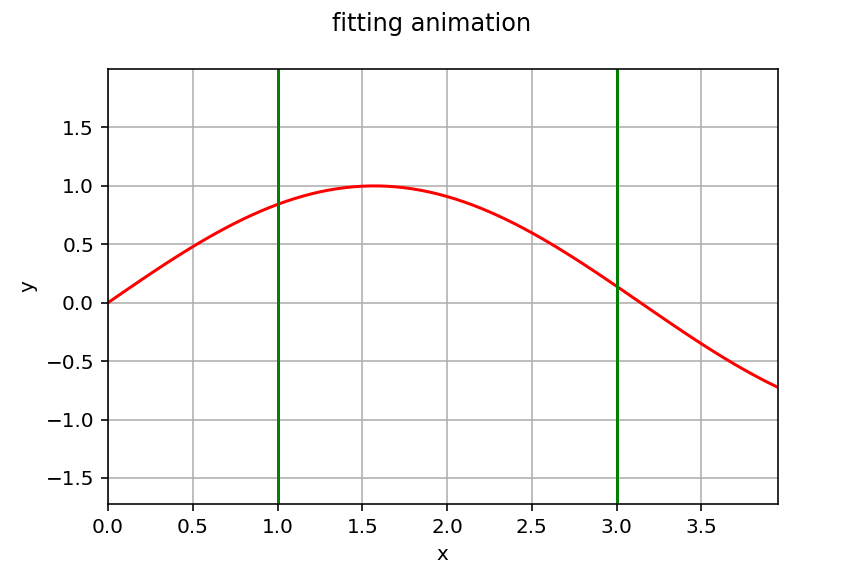

  8%|▊         | 821/10000 [00:01<00:22, 414.13it/s]

end learning...


<IPython.core.display.Javascript object>


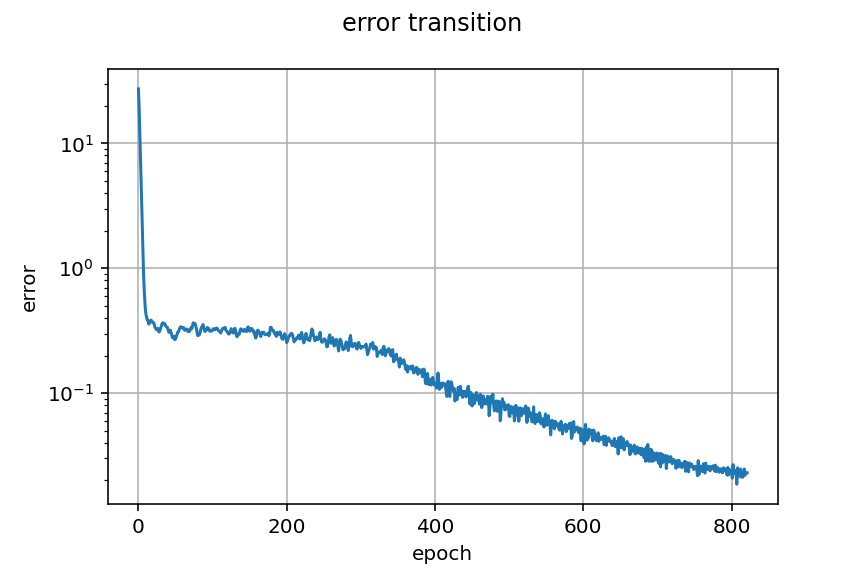

In [1124]:
%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import tqdm


# 学習対象設定
def split_test(target, train_indices):
    return (target[train_indices], target[~ train_indices])
x = np.arange(0, 4, 5e-2)
y = np.sin(x)
x_left = 1
x_right = 3
y_top = np.max(y) + 1
y_bottom = np.min(y) - 1
indices = (x_left <= x) & (x <= x_right)
x_train, x_test = split_test(x, indices)
y_train, y_test = split_test(y, indices)

# 初期設定
epoch = 10000
#error_prev = 0
#error = 0
#error_list = []
threshold = 1e-5
n_batch = 4
#n_train = x_train.size//n_batch
#n_test = x_test.size

# ネットワーク構築
n_in = 1
n_out = 1
lm = LayerManager((x_train, x_test), (y_train, y_test))
lm.append(prev=n_in, n=30, act="sigmoid", wb_width=1)
lm.append(n=30, act="sigmoid", wb_width=1)
lm.append(n=n_out, name="o", act="identity", wb_width=1)

# アニメーションプロット用土台作成
n_image = 100
interval = 100
fig, ax = lm.ready_anim(n_image, x, y, title="fitting animation")
#images = []
#fig, ax = plt.subplots(1)
#fig.suptitle("fitting animation")
#ax.set_xlabel("x")
#ax.set_ylabel("y")
#ax.set_xlim(np.min(x), np.max(x))
#ax.set_ylim(y_bottom, y_top)
#ax.grid()
#ax.plot(x, y, color="r")
ax.plot(np.full_like(np.arange(y_bottom, y_top+1), x_left),
             np.arange(y_bottom, y_top+1),
             color="g")
ax.plot(np.full_like(np.arange(y_bottom, y_top+1), x_right),
             np.arange(y_bottom, y_top+1),
             color="g")

# 学習開始
lm.training(epoch, threshold=threshold, n_batch=n_batch)
#rand_index = np.arange(x_train.size)
#for t in tqdm.tqdm(range(1, epoch+1)):
#    # シーン作成
#    if t % (epoch/n_image) == 1:
#        #x_in = x.reshape(-1, 1)
#        x_in = input_data.reshape(-1, 1)
#        for ll in lm.layer_list:
#            x_in = ll.forward(x_in)
#        im, = ax.plot(x, ll.y, color="b")
#        images.append([im])
#    
#    # 誤差計算
#    x_in = x_test.reshape(n_test, n_in)
#    for ll in lm.layer_list:
#        x_in = ll.forward(x_in)
#    error = lm[-1].get_error(y_test.reshape(n_test, n_out))
#    error_list.append(error)
#
#    # 収束判定
#    if abs(error - error_prev) < threshold:
#        print("end learning...")
#        break
#    else:
#        error_prev = error
#
#    #print("t", t)
#    np.random.shuffle(rand_index)
#    for i in range(n_train):
#        rand = rand_index[i*n_in : (i+n_batch)*n_in]
#
#        x_in = x_train[rand].reshape(-1, n_in)
#        #print("x_in", x_in)
#        for ll in lm.layer_list:
#            x_in = ll.forward(x_in)
#
#        y_in = y_train[rand].reshape(-1, n_out)
#        #print("y_in", y_in)
#        for ll in lm.layer_list[::-1]:
#            y_in = ll.backward(y_in)
#
#        for ll in lm.layer_list:
#            ll.update()

# フィッティングアニメーション作成
anim = animation.ArtistAnimation(lm.anim_fig, lm.images,
                                                            interval=interval, repeat_delay=3000)
#anim = animation.ArtistAnimation(fig, images, interval=interval, repeat_delay=3000)

# 誤差遷移表示
#fig2, ax2 = plt.subplots(1)
#fig2.suptitle("error transition")
#ax2.set_yscale("log")
#ax2.set_xlabel("epoch")
#ax2.set_ylabel("error")
#ax2.grid()
#ax2.plot(error_list)
#fig2.show()
#fig2.savefig("error_transition.png")

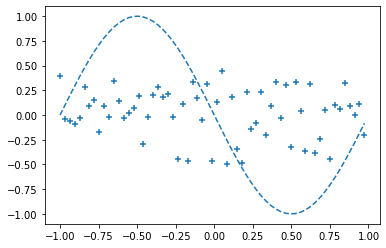

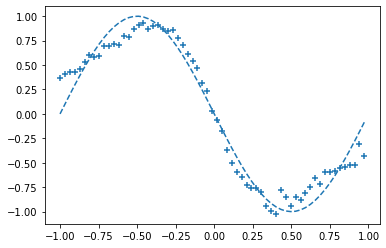

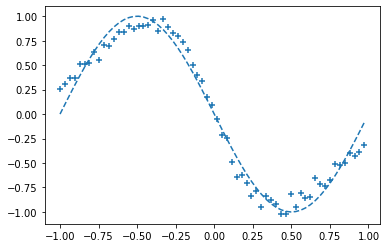

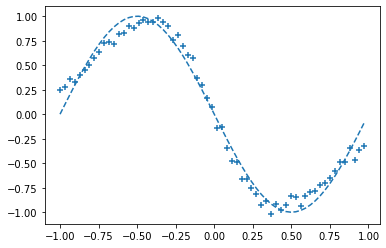

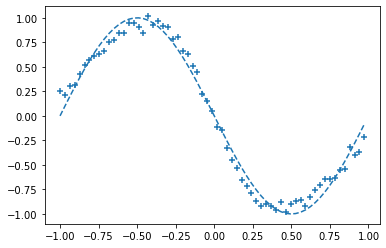

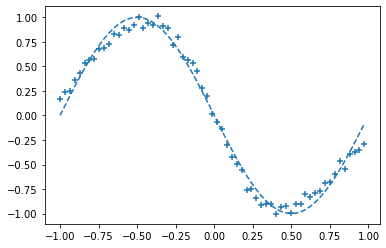

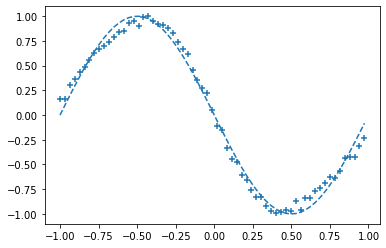

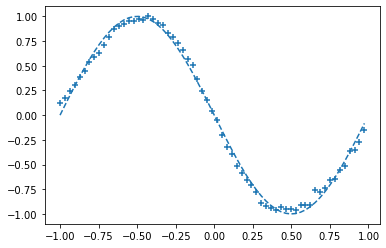

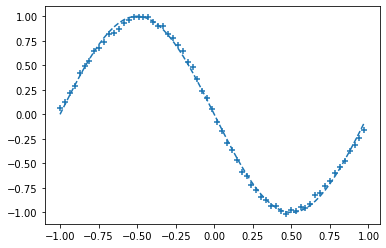

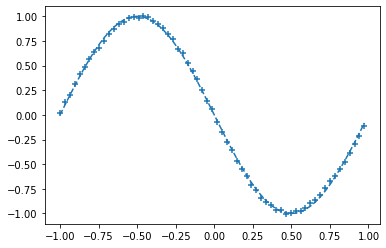

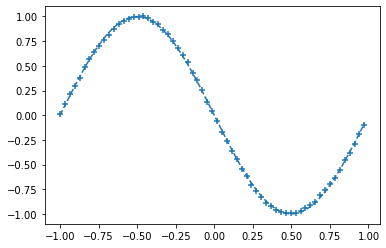

In [1102]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


input_data = np.arange(0, np.pi*2, 0.1)
correct_data = np.sin(input_data)
input_data = (input_data - np.pi)/np.pi
n_data = len(correct_data)

n_in = 1
n_mid = 3
n_out = 1

wb_width = 0.1
eta = 0.1
epoch = 2001
interval = 200

class MiddleLayer:
    def __init__(self, n_upper, n):
        self.w = wb_width * np.random.randn(n_upper, n)
        self.b = wb_width * np.random.randn(n)
    
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = 1/(1+np.exp(-u))
    
    def backward(self, grad_y):
        delta = grad_y * (1-self.y)*self.y
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)
    
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

class OutputLayer:
    def __init__(self, n_upper, n):
        self.w = wb_width * np.random.randn(n_upper, n)
        self.b = wb_width * np.random.randn(n)
    
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = u
    
    def backward(self, t):
        delta = self.y - t
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)
    
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

ml = MiddleLayer(n_in, n_mid)
ol = OutputLayer(n_mid, n_out)

for i in range(epoch):
    index_random = np.arange(n_data)
    np.random.shuffle(index_random)
    
    total_error = 0
    plot_x = []
    plot_y = []
    
    for idx in index_random:
        x = input_data[idx:idx+1]
        t = correct_data[idx:idx+1]
        
        ml.forward(x.reshape(1, 1))
        ol.forward(ml.y)
        
        ol.backward(t.reshape(1, 1))
        ml.backward(ol.grad_x)
        
        ml.update(eta)
        ol.update(eta)
        
        if i % interval == 0:
            y = ol.y.reshape(-1)
            total_error += 0.5*np.sum(np.square(y-t))
            plot_x.append(x)
            plot_y.append(y)
    
    if i % interval == 0:
        plt.plot(input_data, correct_data, linestyle="dashed")
        plt.scatter(plot_x, plot_y, marker="+")
        plt.show()